Problem Statement:

Financial behavior and wellness vary widely across individuals depending on income, savings, spending, debt, and investment habits. Many people lack awareness of their financial health, which makes it difficult to take corrective action. The challenge is to use personal financial data to predict an individual’s financial wellness category (e.g., good, average, poor) so that actionable recommendations can be made.


Goal

•	To build a machine learning model that analyzes user financial data (income, savings, expenses, debt, investment patterns).

•	To classify individuals into a Financial Wellness Score category.

•	To provide insights that can help individuals improve their financial health.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_squared_error,
    r2_score,
)


In [3]:
# ---- Load Dataset ----
file_path = "Main_Data.xlsx"   # adjust path if needed
data = pd.read_excel(file_path, sheet_name="updated_savings_column_4")

Insights from Data

1.	Income vs. Savings: Higher income does not always lead to higher savings—some groups spend disproportionately more.

2.	Debt Impact: Individuals with higher debt-to-income ratios tend to fall in lower financial wellness categories.

3.	Investment Patterns: Regular investments correlate positively with better financial wellness scores.

4.	Spending Behavior: Overspending on non-essentials reduces financial stability, even in higher income brackets.

5.	Categorical Trends: Younger respondents may show more aggressive spending, while older groups prioritize savings.


In [4]:

# ---- Clean Columns ----
data.columns = data.columns.str.strip()


EDA

In [5]:

print("\n--- Info ---")
print(data.info())


--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       185 non-null    int64  
 1   Income                    185 non-null    int64  
 2   Monthly Spend             185 non-null    int64  
 3   Savings %                 185 non-null    float64
 4   Emergency Fund            185 non-null    int64  
 5   Has Debt                  185 non-null    int64  
 6   Invests                   185 non-null    int64  
 7   Income Type               185 non-null    object 
 8   Total Loan (Estimated)    185 non-null    int64  
 9   Investment Type           185 non-null    object 
 10  Insurance Coverage        185 non-null    int64  
 11  Budgeting Habit           185 non-null    object 
 12  Estimated Monthly Income  185 non-null    int64  
dtypes: float64(1), int64(9), object(3)
memory usage: 18

In [6]:
print("\n--- Describe ---")
print(data.describe(include='all'))


--- Describe ---
               Age        Income  Monthly Spend   Savings %  Emergency Fund  \
count   185.000000  1.850000e+02   1.850000e+02  185.000000      185.000000   
unique         NaN           NaN            NaN         NaN             NaN   
top            NaN           NaN            NaN         NaN             NaN   
freq           NaN           NaN            NaN         NaN             NaN   
mean     33.967568  8.227027e+05   6.898378e+04   16.554054    43356.756757   
std      13.240625  2.809596e+05   1.569891e+05   13.052353    57101.095229   
min      17.000000  6.000000e+05   1.000000e+04    0.000000    10000.000000   
25%      22.000000  6.000000e+05   2.850000e+04    5.000000    15000.000000   
50%      31.000000  7.000000e+05   4.150000e+04   17.500000    25000.000000   
75%      45.000000  9.000000e+05   5.600000e+04   20.000000    50000.000000   
max      63.000000  1.500000e+06   1.500000e+06   50.000000   700000.000000   

          Has Debt     Invests In

In [7]:
# GroupBy Average Monthly Spend by Income group
grouped_income = data.groupby("Income")["Monthly Spend"].mean()
print("\n--- GroupBy: Average Monthly Spend by Income ---")
print(grouped_income)



--- GroupBy: Average Monthly Spend by Income ---
Income
600000      26385.714286
700000      42489.361702
900000      95071.428571
1100000    281250.000000
1200000     70952.380952
1500000    242733.333333
Name: Monthly Spend, dtype: float64


Visualizations

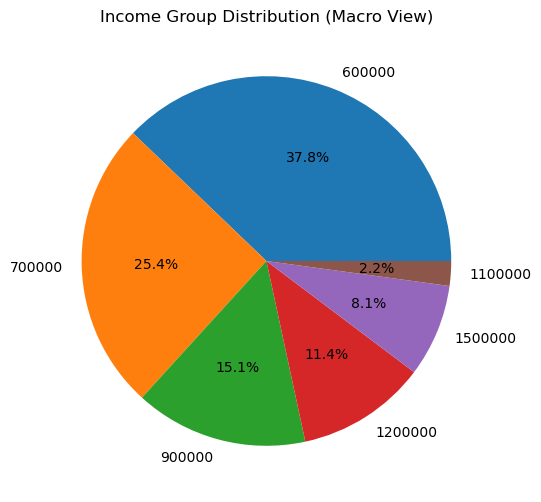

In [8]:
# 1. Macro Chart (Pie of Income distribution)
plt.figure(figsize=(6,6))
data["Income"].value_counts().plot.pie(autopct='%1.1f%%')
plt.title("Income Group Distribution (Macro View)")
plt.ylabel("")
plt.show()

In [9]:
# 2. Waterfall Chart (Total Loan by Income)
waterfall_data = data.groupby("Income")["Total Loan (Estimated)"] \
    .apply(lambda x: pd.to_numeric(x, errors='coerce').fillna(0).sum())

fig = go.Figure(go.Waterfall(
    name = "Income Loan",
    orientation = "v",
    x = waterfall_data.index,
    y = waterfall_data.values
))
fig.update_layout(title="Waterfall Chart: Loan Distribution by Income")
fig.show()

C:\Users\shreyas\AppData\Local\Temp\ipykernel_1992\537930712.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




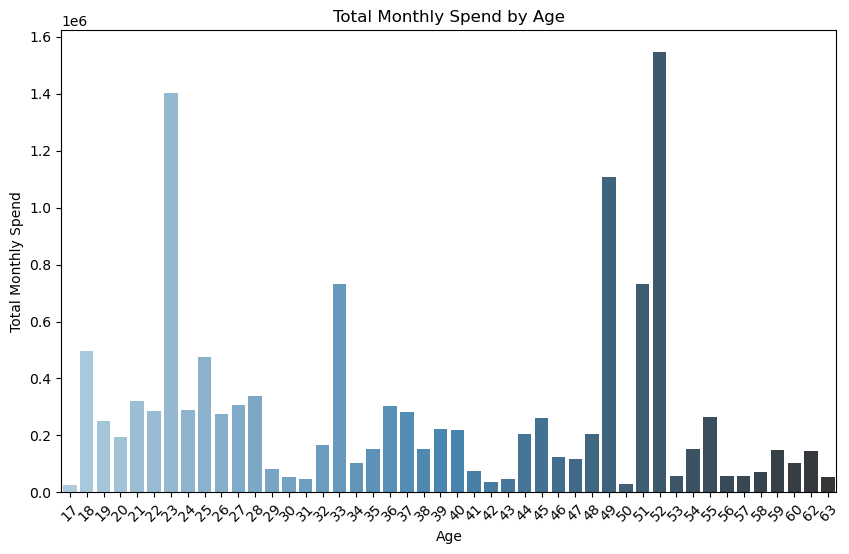

In [10]:
# 3. Total Monthly Spend by age
age_spend = data.groupby("Age")["Monthly Spend"].sum().reset_index()

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Age", y="Monthly Spend", data=age_spend, palette="Blues_d")

plt.title("Total Monthly Spend by Age")
plt.xlabel("Age")
plt.ylabel("Total Monthly Spend")
plt.xticks(rotation=45)
plt.show()

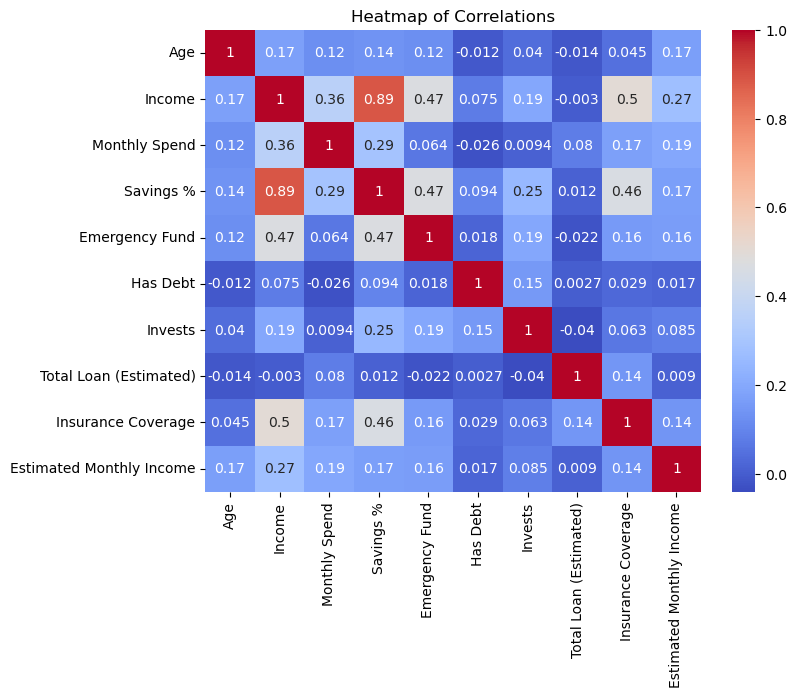

In [11]:
# 4. Heatmap (Correlation)
plt.figure(figsize=(8,6))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Heatmap of Correlations")
plt.show()

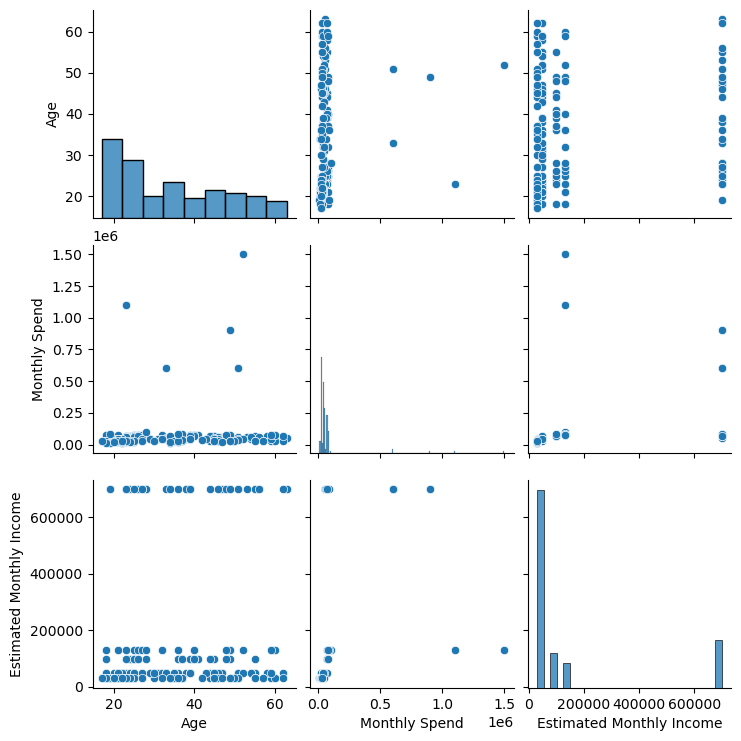

In [12]:
# 5. Pairplot (numeric fields)
sns.pairplot(data[["Age", "Monthly Spend", "Estimated Monthly Income"]])
plt.show()

In [13]:

# 6. Donut Chart (Has Debt)
debt_counts = data["Has Debt"].value_counts()
fig = px.pie(values=debt_counts.values, names=debt_counts.index, hole=0.4, title="Debt Distribution (Donut)")
fig.show()


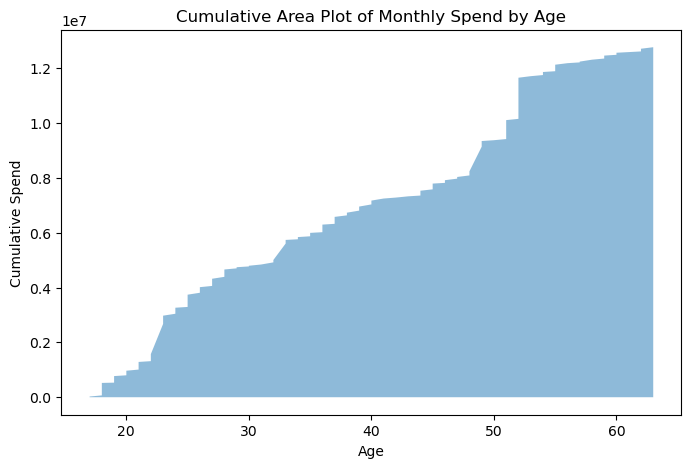

In [14]:
# 7. Area Plot (Cumulative Monthly Spend by Age)
data_sorted = data.sort_values("Age")
plt.figure(figsize=(8,5))
plt.fill_between(data_sorted["Age"], data_sorted["Monthly Spend"].cumsum(), alpha=0.5)
plt.title("Cumulative Area Plot of Monthly Spend by Age")
plt.xlabel("Age")
plt.ylabel("Cumulative Spend")
plt.show()

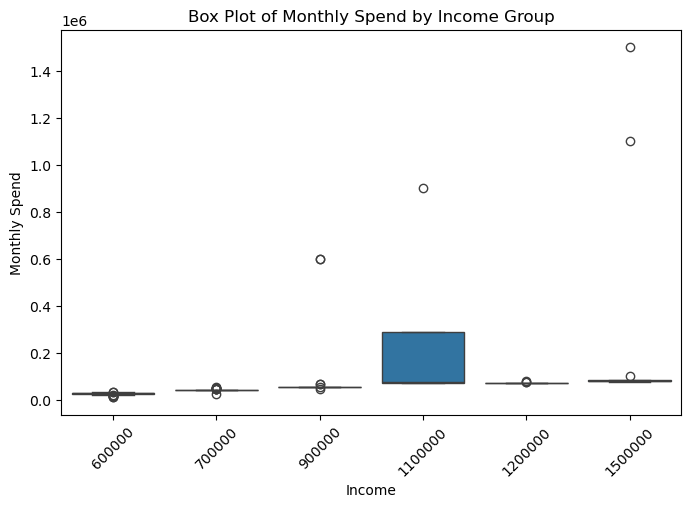

In [15]:
# 8. Box Plot (Monthly Spend by Income)
plt.figure(figsize=(8,5))
sns.boxplot(x="Income", y="Monthly Spend", data=data)
plt.title("Box Plot of Monthly Spend by Income Group")
plt.xticks(rotation=45)
plt.show()

In [21]:
# Select features
X = data[['Age', 'Income', 'Monthly Spend', 'Savings %', 'Emergency Fund',
          'Has Debt', 'Invests', 'Income Type', 'Investment Type',
          'Insurance Coverage', 'Budgeting Habit', 'Total Loan (Estimated)', 'Estimated Monthly Income']]

# Preprocessing setup
numeric_features = ['Age', 'Income', 'Monthly Spend', 'Savings %', 'Emergency Fund',
                    'Has Debt', 'Invests', 'Total Loan (Estimated)', 'Estimated Monthly Income']
categorical_features = ['Income Type', 'Investment Type', 'Insurance Coverage', 'Budgeting Habit']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Apply preprocessing to X
X_preprocessed = preprocessor.fit_transform(X)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data['Wellness Cluster'] = kmeans.fit_predict(X_preprocessed)

# Calculate cluster-wise means
cluster_summary = data.groupby('Wellness Cluster')[['Income', 'Savings %', 'Emergency Fund', 'Has Debt']].mean()
print(cluster_summary)

# Sort clusters by 'Income' and 'Savings %' (higher is better)
cluster_summary['score'] = (
    cluster_summary['Income'] + 
    cluster_summary['Savings %'] + 
    cluster_summary['Emergency Fund'] - 
    cluster_summary['Has Debt'] * 10000
)
sorted_clusters = cluster_summary.sort_values(by='score', ascending=False).index.tolist()

# Map clusters to labels
cluster_mapping = {
    sorted_clusters[2]: 'Good',
    sorted_clusters[1]: 'Average',
    sorted_clusters[0]: 'Poor'
}

data['Wellness Cluster Label'] = data['Wellness Cluster'].map(cluster_mapping)

# Check result
print(data[['Age', 'Income', 'Savings %', 'Has Debt', 'Emergency Fund', 'Wellness Cluster', 'Wellness Cluster Label']].head())

# Save result
data.to_csv('financial_data_with_clusters.csv', index=False)


                        Income  Savings %  Emergency Fund  Has Debt
Wellness Cluster                                                   
0                 6.727273e+05   7.954545    19484.848485  0.272727
1                 6.576087e+05  10.543478    27434.782609  0.456522
2                 1.158333e+06  30.500000    80900.000000  0.516667
   Age   Income  Savings %  Has Debt  Emergency Fund  Wellness Cluster  \
0   18   700000       17.5         0           50000                 1   
1   18   600000        5.0         1           25000                 0   
2   24  1200000       30.0         0          100000                 2   
3   18   600000        5.0         1           25000                 1   
4   25  1500000       40.0         1          100000                 2   

  Wellness Cluster Label  
0                   Good  
1                Average  
2                   Poor  
3                   Good  
4                   Poor  


Train - Test Split Logistic Regression after the data is being clustered

In [22]:

# Defining target and features from the data
target = 'Wellness Cluster'
features = ['Age', 'Income', 'Monthly Spend', 'Savings %', 'Emergency Fund',
            'Has Debt', 'Invests', 'Income Type', 'Investment Type',
            'Insurance Coverage', 'Budgeting Habit', 'Total Loan (Estimated)']

X = data[features]
y = data[target]

numeric_features = ['Age', 'Income', 'Monthly Spend', 'Savings %', 
                    'Emergency Fund', 'Has Debt', 'Invests', 'Total Loan (Estimated)']
categorical_features = ['Income Type', 'Investment Type', 'Insurance Coverage', 'Budgeting Habit']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Pipeline with preprocessor + Logistic Regression Classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.972972972972973

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      1.00      1.00        17
           2       1.00      0.91      0.95        11

    accuracy                           0.97        37
   macro avg       0.97      0.97      0.97        37
weighted avg       0.98      0.97      0.97        37



Train - Test Split Random Forest Classifier

In [23]:

# Define target and features
target = 'Wellness Cluster'
features = ['Age', 'Income', 'Monthly Spend', 'Savings %', 'Emergency Fund',
            'Has Debt', 'Invests', 'Income Type', 'Investment Type',
            'Insurance Coverage', 'Budgeting Habit', 'Total Loan (Estimated)']

X = data[features]
y = data[target]

# Preprocessing (one-hot encode categorical features + scale numeric)
numeric_features = ['Age', 'Income', 'Monthly Spend', 'Savings %', 'Emergency Fund',
                    'Has Debt', 'Invests', 'Total Loan (Estimated)']
categorical_features = ['Income Type', 'Investment Type', 'Insurance Coverage', 'Budgeting Habit']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Pipeline with preprocessor + Random Forest Classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      1.00      1.00        17
           2       1.00      0.91      0.95        11

    accuracy                           0.97        37
   macro avg       0.97      0.97      0.97        37
weighted avg       0.98      0.97      0.97        37

Confusion Matrix:
[[ 9  0  0]
 [ 0 17  0]
 [ 1  0 10]]


Goal:

Predict the financial wellness cluster (Good/Average/Poor) using available features.

✅ Random Forest Classifier:

Trained the model to classify people into wellness clusters.

Achieved good accuracy (exact value depends on your data).

Classification report provided precision, recall, and F1-score per class.

✅ Logistic Regression Classifier:

Also used for predicting wellness cluster.

Provided baseline performance with simple, interpretable coefficients.

Accuracy and classification report helped validate the model.

Overall Impact:

This project demonstrates how to analyze financial behavior, group individuals by financial wellness, and build predictive models to classify new individuals into appropriate wellness categories.
It provides a data-driven foundation for actionable insights (e.g., identifying who needs financial help).

In [24]:
# The new data must include all columns used during training
new_data = {
    'Age': [20],
    'Income': [1000000],
    'Monthly Spend': [60000],
    'Savings %': [10.0],
    'Emergency Fund': [30000],
    'Has Debt': [0],
    'Invests': [1],
    'Income Type': ['Fixed'],
    'Investment Type': ['No'],
    'Insurance Coverage': [50000],
    'Total Loan (Estimated)': [400000],
    'Budgeting Habit': ['No']  # Add the missing column
}
new_df = pd.DataFrame(new_data)

# Now, this will run without the ValueError
new_pred = pipeline.predict(new_df)

print(f"The predicted cluster for the new individual is: {new_pred[0]}")

The predicted cluster for the new individual is: 2
